**Import Libraries**

In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import pandas as pd

# Data Preparation and visualization
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler  
from sklearn.preprocessing import StandardScaler   
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

In [ ]:
#authenticating Google Drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#running on GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul 30 23:20:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#using high-RAM

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#loading the dataset

downloaded = drive.CreateFile({'id':'1famudHl0iFkKjZ2Drge1xNB-mWuk9xS_'}) 
downloaded.GetContentFile('train.csv')  


In [ ]:
downloaded = drive.CreateFile({'id':'1XBInwNISj8HfKpxUFL4kby_wSmmGIA1F'}) 
downloaded.GetContentFile('train_sample.csv')

In [ ]:
downloaded = drive.CreateFile({'id':'192L-WwVNdfbvVqUBLQbItMs4y5wemwD-'}) 
downloaded.GetContentFile('test.csv') 

In [ ]:
adfraud = pd.read_csv('train_sample.csv')

In [ ]:
adfraud_test = pd.read_csv('test.csv')

**Exploring the dataset**

In [ ]:
print("Count of rows and column are: " , adfraud.shape)

Count of rows and column are:  (100000, 8)


In [ ]:
adfraud.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [ ]:
adfraud.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [ ]:
adfraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [ ]:
#number of unique values per feature

for i in adfraud.columns:
    cnt = len(adfraud[i].unique())
    print(i,":",cnt)

ip : 34857
app : 161
device : 100
os : 130
channel : 161
click_time : 80350
attributed_time : 228
is_attributed : 2


In [ ]:
#ip, app, device, os and channel are actually categorical variables encoded as integers
#transform this data types to categories

#variables = ['ip', 'app', 'device', 'os', 'channel']
#for v in variables:
 #   adfraud[v] = adfraud[v].astype('category')
  #  adfraud_test[v]=adfraud_test[v].astype('category')

In [ ]:
#convert click_time and attributed_time to date/time data type

adfraud['click_time'] = pd.to_datetime(adfraud['click_time'])
adfraud['attributed_time'] = pd.to_datetime(adfraud['attributed_time'])
adfraud_test['click_time'] = pd.to_datetime(adfraud_test['click_time'])


In [ ]:
#convert outcome variable (is_attributed) to categorical data type
#adfraud['is_attributed']=adfraud['is_attributed'].astype('category')

In [ ]:
adfraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ip               100000 non-null  int64         
 1   app              100000 non-null  int64         
 2   device           100000 non-null  int64         
 3   os               100000 non-null  int64         
 4   channel          100000 non-null  int64         
 5   click_time       100000 non-null  datetime64[ns]
 6   attributed_time  227 non-null     datetime64[ns]
 7   is_attributed    100000 non-null  int64         
dtypes: datetime64[ns](2), int64(6)
memory usage: 6.1 MB


**Checking Missing Values**

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [ ]:
missing_data(adfraud)

,Total,Percent
attributed_time,99773,99.773
ip,0,0.000
app,0,0.000
device,0,0.000
os,0,0.000
channel,0,0.000
click_time,0,0.000
is_attributed,0,0.000


In [ ]:
missing_data(adfraud_test)

,Total,Percent
click_id,0,0.0
ip,0,0.0
app,0,0.0
device,0,0.0
os,0,0.0
channel,0,0.0
click_time,0,0.0


**Imbalanced Data**

<Figure size 432x288 with 0 Axes>

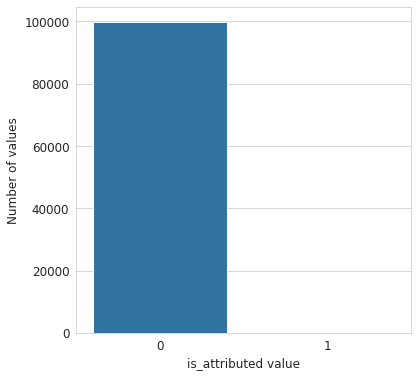

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = adfraud['is_attributed'].value_counts().index.values
y = adfraud["is_attributed"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('is_attributed value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Since the dataset is highly imbalanced, it is recommend to do undersampling.

Classes:

0- User will not download an app after clicking a mobile app advertisement

1- User will download an app after clicking a mobile app advertisement

**Feature Engineering**

In [ ]:
#adding date and time data

adfraud['year'] = pd.to_datetime(adfraud.click_time).dt.year
adfraud['month'] = pd.to_datetime(adfraud.click_time).dt.month
adfraud['day'] = pd.to_datetime(adfraud.click_time).dt.day
adfraud['hour'] = pd.to_datetime(adfraud.click_time).dt.hour
adfraud['min'] = pd.to_datetime(adfraud.click_time).dt.minute
adfraud['sec'] = pd.to_datetime(adfraud.click_time).dt.second
adfraud.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,year,month,day,hour,min,sec
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017,11,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017,11,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017,11,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017,11,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017,11,9,9,0,9


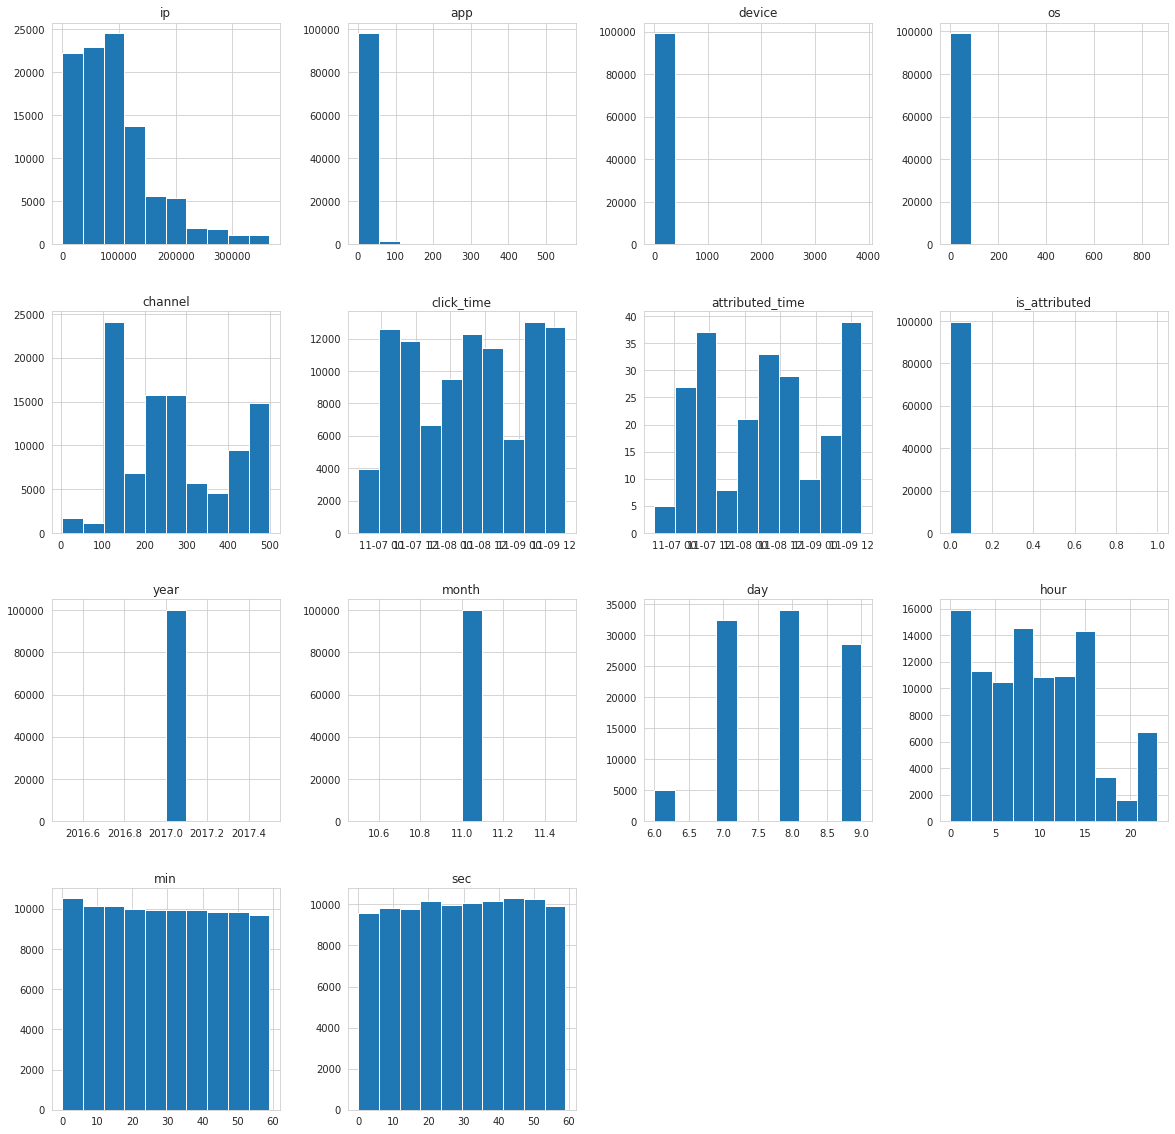

In [ ]:
p = adfraud.hist(figsize = (20,20))

**Checking Time Patterns**

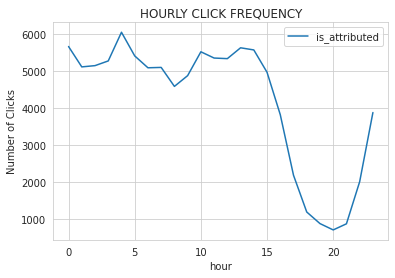

In [ ]:
adfraud[['hour','is_attributed']].groupby(['hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

<Figure size 432x288 with 0 Axes>

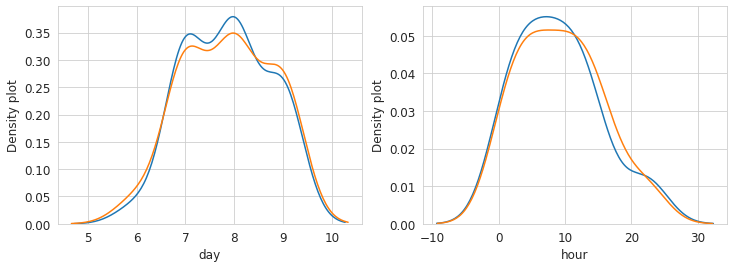

In [ ]:
var = ['day','hour']

i = 0
t1 = adfraud.loc[adfraud['is_attributed'] != 0]
t0 = adfraud.loc[adfraud['is_attributed'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,4))

for feature in var:
    i += 1
    plt.subplot(1,2,i)
    sns.kdeplot(t1[feature], bw=0.5,label="is_attributed = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="is_attributed = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Modeling

In [ ]:
adfraud['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

Label Encoding

In [ ]:
from sklearn import preprocessing

cat_features = ['ip', 'app', 'device', 'os', 'channel']
lable_encoder = preprocessing.LabelEncoder()

for feature in cat_features:
    encoded = lable_encoder.fit_transform(adfraud[feature])
    adfraud[feature +'_labels'] = encoded

In [ ]:
adfraud.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,year,month,day,hour,min,sec,ip_labels,app_labels,device_labels,os_labels,channel_labels
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017,11,7,9,30,38,15220,11,1,13,159
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017,11,7,13,40,27,18448,24,1,17,67
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017,11,7,18,5,24,17663,11,1,19,52
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017,11,7,4,58,8,16496,12,1,13,146
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017,11,9,9,0,9,11852,11,1,1,45


In [ ]:
feature_cols = ['day', 'hour', 'min', 'sec', 
                'ip_labels', 'app_labels', 'device_labels',
                'os_labels', 'channel_labels']

In [ ]:
target_label=adfraud['is_attributed']
target_label.shape

(100000,)

In [ ]:
ones=adfraud[adfraud['is_attributed']==1]
zeros=adfraud[adfraud['is_attributed']==0]

In [ ]:
adfraud_train=adfraud.drop(['is_attributed','ip','attributed_time','click_time','app','device','os','channel','year','month'],axis=1)

In [ ]:
#split train set into train set and validation set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(adfraud_train,target_label,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(80000, 9) (80000,)
(20000, 9) (20000,)


In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=42)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(72000, 9) (72000,)
(8000, 9) (8000,)


In [ ]:
x_test.head()

,day,hour,min,sec,ip_labels,app_labels,device_labels,os_labels,channel_labels
75721,9,14,28,56,8449,13,1,34,149
80184,8,18,52,43,15418,1,1,22,146
19864,9,14,41,16,8400,10,1,12,150
76699,9,10,51,37,18705,22,1,13,40
92991,9,12,24,7,3585,25,1,32,24


In [ ]:
adfraud_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   day             100000 non-null  int64
 1   hour            100000 non-null  int64
 2   min             100000 non-null  int64
 3   sec             100000 non-null  int64
 4   ip_labels       100000 non-null  int64
 5   app_labels      100000 non-null  int64
 6   device_labels   100000 non-null  int64
 7   os_labels       100000 non-null  int64
 8   channel_labels  100000 non-null  int64
dtypes: int64(9)
memory usage: 6.9 MB


LGBM Model

In [ ]:
import lightgbm as lgb

In [ ]:
#load datasets in lgb formate
train_data=lgb.Dataset(x_train,label=y_train,free_raw_data=False)
validation_data=lgb.Dataset(x_val,label=y_val,free_raw_data=False)

LGBM Basemodel

In [ ]:
#LGBM Baseline

#set parameters for training
params={ 'num_leaves':160,
        'object':'binary',
        'metric':['auc','binary_logloss']
       }

In [ ]:
#Original LGB model before sampling
num_round=100
def lgb_basemodel(x_train,y_train):
    lgb_model=lgb.train(params,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=20)
    return lgb_model

LGBM model with Downsampling

In [ ]:
#LGBM model after resampling the data using Under sampling techniques
from imblearn.under_sampling import RandomUnderSampler 
def lgb_downsampling(x_train,y_train):
    lgb_enn=RandomUnderSampler(random_state=42)
    x_resample,y_resample=lgb_enn.fit_resample(x_train,y_train)
    train_data=lgb.Dataset(x_resample,label=y_resample,free_raw_data=False)
    lgb_model=lgb.train(params,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=20)
    return lgb_model,x_resample,y_resample;

LGBM with Unsampling

In [ ]:
#LGBM model after resampling the data using Up sampling techniques
from imblearn.over_sampling import SMOTE  #Balances the classes by performing upsampling on minority class
def lgb_upsampling(x_train,y_train):
    lgb_smote= SMOTE(random_state=42)
    x_resample,y_resample=lgb_smote.fit_resample(x_train,y_train)
    train_data=lgb.Dataset(x_resample,label=y_resample)
    lgb_model=lgb.train(params,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=20)
    return lgb_model,x_resample,y_resample;

LGBM with Upweighting

In [ ]:
weight_factor=zeros.shape[0]/ones.shape[0]  # Ratio of number of samples in majority class to number of samples in minority class
print('Weight factor is %0.2f'%(weight_factor))

Weight factor is 439.53


In [ ]:
#set parameters for training
params1={ 'num_leaves':160,
        'object':'binary',
        'metric':['auc','binary_logloss'],
        'scale_pos_weight':397.41                 #Weight of minority class
       }

In [ ]:
#LGBM model using Upweighting technique for handling the imbalanced data
def lgb_Upweighting(x_train,y_train):
    lgb_model=lgb.train(params1,train_data,num_round,valid_sets=validation_data,early_stopping_rounds=20)
    return lgb_model;

Train LGBM Models

In [ ]:
#Basemodel
lgb_basemodel=lgb_basemodel(x_train,y_train)

[1]	valid_0's binary_logloss: 0.0125899	valid_0's auc: 0.888928
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.0115413	valid_0's auc: 0.892887
[3]	valid_0's binary_logloss: 0.0107108	valid_0's auc: 0.879506
[4]	valid_0's binary_logloss: 0.0101562	valid_0's auc: 0.904696
[5]	valid_0's binary_logloss: 0.00988042	valid_0's auc: 0.895431
[6]	valid_0's binary_logloss: 0.010985	valid_0's auc: 0.883048
[7]	valid_0's binary_logloss: 0.0108584	valid_0's auc: 0.888127
[8]	valid_0's binary_logloss: 0.010657	valid_0's auc: 0.880263
[9]	valid_0's binary_logloss: 0.0105385	valid_0's auc: 0.8717
[10]	valid_0's binary_logloss: 0.0105274	valid_0's auc: 0.86888
[11]	valid_0's binary_logloss: 0.0104968	valid_0's auc: 0.855429
[12]	valid_0's binary_logloss: 0.0105288	valid_0's auc: 0.854532
[13]	valid_0's binary_logloss: 0.0106691	valid_0's auc: 0.847762
[14]	valid_0's binary_logloss: 0.0109215	valid_0's auc: 0.842197
[15]	valid_0's binary_logloss: 0.0135806	

In [ ]:
#Downsampling model
lgb_downsampling,x_down,y_down=lgb_downsampling(x_train,y_train)


[1]	valid_0's binary_logloss: 0.636164	valid_0's auc: 0.886023
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.585462	valid_0's auc: 0.887124
[3]	valid_0's binary_logloss: 0.549718	valid_0's auc: 0.873846
[4]	valid_0's binary_logloss: 0.514737	valid_0's auc: 0.883782
[5]	valid_0's binary_logloss: 0.485303	valid_0's auc: 0.871237
[6]	valid_0's binary_logloss: 0.457106	valid_0's auc: 0.872306
[7]	valid_0's binary_logloss: 0.437631	valid_0's auc: 0.877733
[8]	valid_0's binary_logloss: 0.418252	valid_0's auc: 0.887809
[9]	valid_0's binary_logloss: 0.400665	valid_0's auc: 0.886734
[10]	valid_0's binary_logloss: 0.383021	valid_0's auc: 0.887835
[11]	valid_0's binary_logloss: 0.369222	valid_0's auc: 0.888546
[12]	valid_0's binary_logloss: 0.354604	valid_0's auc: 0.895097
[13]	valid_0's binary_logloss: 0.34366	valid_0's auc: 0.892275
[14]	valid_0's binary_logloss: 0.33173	valid_0's auc: 0.891295
[15]	valid_0's binary_logloss: 0.322259	valid_0's auc

In [ ]:
y_down_df=pd.DataFrame(y_down)
y_down.shape

(318,)

In [ ]:
#Upsampling model
lgb_upsampling,x_up,y_up=lgb_upsampling(x_train,y_train)

[1]	valid_0's binary_logloss: 0.604525	valid_0's auc: 0.888985
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.532117	valid_0's auc: 0.879372
[3]	valid_0's binary_logloss: 0.470888	valid_0's auc: 0.883315
[4]	valid_0's binary_logloss: 0.419274	valid_0's auc: 0.882047
[5]	valid_0's binary_logloss: 0.374796	valid_0's auc: 0.875014
[6]	valid_0's binary_logloss: 0.336245	valid_0's auc: 0.914517
[7]	valid_0's binary_logloss: 0.303507	valid_0's auc: 0.916753
[8]	valid_0's binary_logloss: 0.274258	valid_0's auc: 0.920257
[9]	valid_0's binary_logloss: 0.248308	valid_0's auc: 0.923661
[10]	valid_0's binary_logloss: 0.225028	valid_0's auc: 0.924192
[11]	valid_0's binary_logloss: 0.204954	valid_0's auc: 0.926933
[12]	valid_0's binary_logloss: 0.187233	valid_0's auc: 0.931649
[13]	valid_0's binary_logloss: 0.171432	valid_0's auc: 0.932651
[14]	valid_0's binary_logloss: 0.157156	valid_0's auc: 0.929873
[15]	valid_0's binary_logloss: 0.144506	valid_0's a

In [ ]:
#Upweighting model 
lgb_upweighting=lgb_Upweighting(x_train,y_train);

[1]	valid_0's binary_logloss: 0.0122057	valid_0's auc: 0.789604
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.0110713	valid_0's auc: 0.79064
[3]	valid_0's binary_logloss: 0.0106276	valid_0's auc: 0.818909
[4]	valid_0's binary_logloss: 0.0103406	valid_0's auc: 0.927755
[5]	valid_0's binary_logloss: 0.0102605	valid_0's auc: 0.938262
[6]	valid_0's binary_logloss: 0.00989805	valid_0's auc: 0.943903
[7]	valid_0's binary_logloss: 0.00958278	valid_0's auc: 0.955914
[8]	valid_0's binary_logloss: 0.00937624	valid_0's auc: 0.918385
[9]	valid_0's binary_logloss: 0.00912035	valid_0's auc: 0.929575
[10]	valid_0's binary_logloss: 0.00925249	valid_0's auc: 0.878812
[11]	valid_0's binary_logloss: 0.00934405	valid_0's auc: 0.879641
[12]	valid_0's binary_logloss: 0.0092731	valid_0's auc: 0.876609
[13]	valid_0's binary_logloss: 0.0129403	valid_0's auc: 0.828617
[14]	valid_0's binary_logloss: 0.0131262	valid_0's auc: 0.831734
[15]	valid_0's binary_logloss: 0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scikitplot as skplt

In [ ]:
y_upsampling=lgb_upsampling.predict(x_test)

In [ ]:
y_downsampling=lgb_downsampling.predict(x_test)

In [ ]:
y_upweighting=lgb_upweighting.predict(x_test)

In [ ]:
y_base=lgb_basemodel.predict(x_test)

AttributeError: ignored

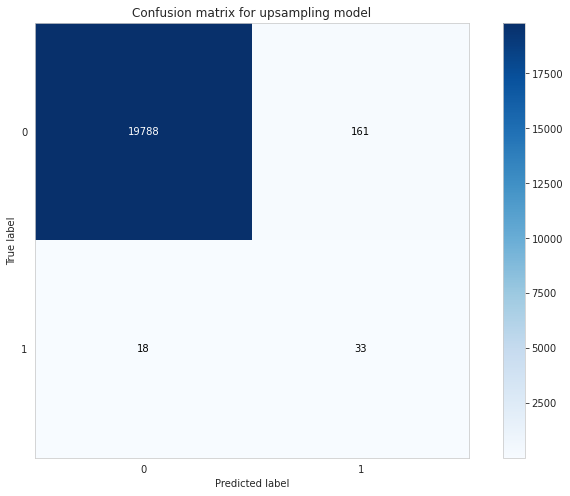

In [ ]:
#upsampling
skplt.metrics.plot_confusion_matrix(y_test,y_upsampling>0.5,normalize=False,figsize=(12,8),title='Confusion matrix for upsampling model')  #0.5 is threshold value
plt.show()

In [ ]:
#Upsampling model
cm_up=classification_report(y_test,y_upsampling>0.5)
print(cm_up)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19949
           1       0.17      0.65      0.27        51

    accuracy                           0.99     20000
   macro avg       0.58      0.82      0.63     20000
weighted avg       1.00      0.99      0.99     20000



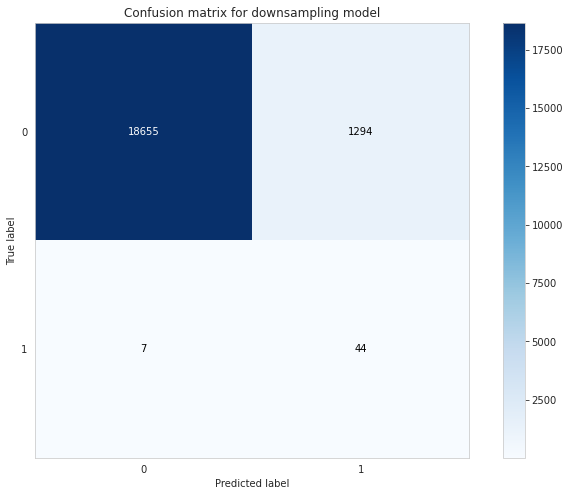

In [ ]:
#downsampling
skplt.metrics.plot_confusion_matrix(y_test,y_downsampling>0.5,normalize=False,figsize=(12,8),title='Confusion matrix for downsampling model')  #0.5 is threshold value
plt.show()

In [ ]:
#Downsampling model
cm_up=classification_report(y_test,y_downsampling>0.5)
print(cm_up)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19949
           1       0.03      0.86      0.06        51

    accuracy                           0.93     20000
   macro avg       0.52      0.90      0.51     20000
weighted avg       1.00      0.93      0.96     20000



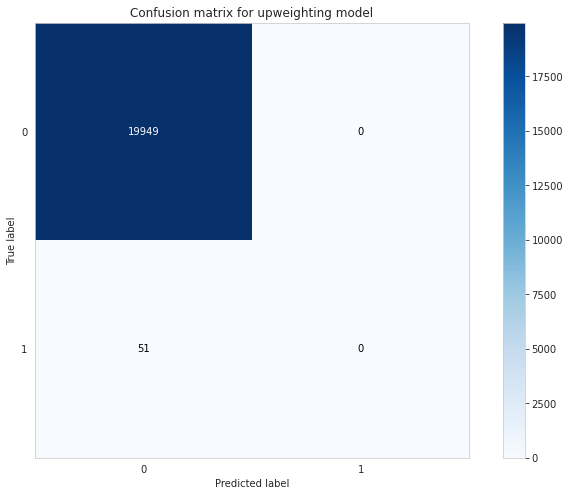

In [ ]:
#Upweighting
skplt.metrics.plot_confusion_matrix(y_test,y_upweighting>0.5,normalize=False,figsize=(12,8),title='Confusion matrix for upweighting model')  #0.5 is threshold value
plt.show()

In [ ]:
#Upweighting model
cm_upweight=classification_report(y_test,y_upweighting>0.5)  # 0.5 is threshold value
print(cm_upweight)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19949
           1       0.00      0.00      0.00        51

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.99      1.00      1.00     20000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# List feature importance for all features
print("Features importance...")
gain = lgb_upsampling.feature_importance('gain')
ft = pd.DataFrame({'feature':lgb_upsampling.feature_name(), 
                   'split':lgb_upsampling.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(ft)

Features importance...
          feature  split       gain
5      app_labels   1267  39.812532
6   device_labels    496  21.384465
4       ip_labels   1924  16.329615
8  channel_labels   1504  11.790749
7       os_labels    847   2.515884
1            hour    727   2.337932
2             min    775   2.152478
3             sec    791   1.974634
0             day    414   1.701711


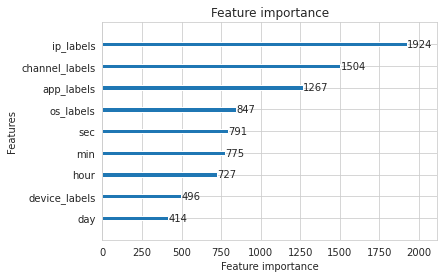

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot feature importance using the "split" method
split = lgb.plot_importance(lgb_upsampling, importance_type="split")
plt.show(split) # Show the plot
plt.savefig("feature_importance_split.png") # Save the plot in the output

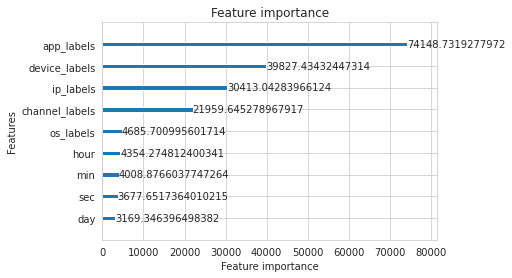

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot feature importance using the "gain" method
gain = lgb.plot_importance(lgb_upsampling, importance_type="gain")
plt.show(gain)
plt.savefig("feature_importance_gain.png")

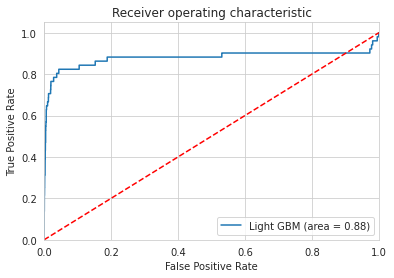

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, y_upsampling)
fpr, tpr, thresholds = roc_curve(y_test, y_upsampling)
plt.figure()
plt.plot(fpr, tpr, label='Light GBM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [ ]:
XGB_model = XGBClassifier()
XGB_model.fit(x_train,y_train)

y_pred3 =XGB_model.predict_proba(x_val)
y_pred3[:10]

array([[9.9982142e-01, 1.7855964e-04],
       [9.9698722e-01, 3.0128001e-03],
       [9.9967617e-01, 3.2382060e-04],
       [9.9864763e-01, 1.3523875e-03],
       [9.9975955e-01, 2.4041905e-04],
       [9.9983990e-01, 1.6007332e-04],
       [9.9983305e-01, 1.6697648e-04],
       [9.9942201e-01, 5.7801354e-04],
       [9.9935830e-01, 6.4172916e-04],
       [9.9977827e-01, 2.2173941e-04]], dtype=float32)

In [ ]:
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


In [ ]:
ROC_Score=metrics.roc_auc_score(y_val,y_pred3[:,1])
print("ROC Score of XGBoost Model :%.2f%%" % (ROC_Score * 100.0) )

ROC Score of XGBoost Model :91.10%


In [ ]:
XGBC_model = XGBClassifier(max_depth=2,
                                       n_estimators=100,
                                       learning_rate=0.1,
                                       subsample=0.6)
XGBC_model.fit(x_train,y_train)
y_pred4=XGBC_model.predict_proba(x_val)
y_pred4[:10]

array([[9.9977684e-01, 2.2314407e-04],
       [9.9816293e-01, 1.8370751e-03],
       [9.9964964e-01, 3.5036428e-04],
       [9.9834275e-01, 1.6572269e-03],
       [9.9959052e-01, 4.0949229e-04],
       [9.9976981e-01, 2.3019132e-04],
       [9.9976701e-01, 2.3299833e-04],
       [9.9935710e-01, 6.4289960e-04],
       [9.9940062e-01, 5.9938733e-04],
       [9.9962419e-01, 3.7581654e-04]], dtype=float32)

In [ ]:
ROC_Score=metrics.roc_auc_score(y_val,y_pred4[:,1])
print("ROC Score of Hyperparameter Tunned XGBoost Model :%.2f%%" % (ROC_Score * 100.0) )

ROC Score of Hyperparameter Tunned XGBoost Model :91.77%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


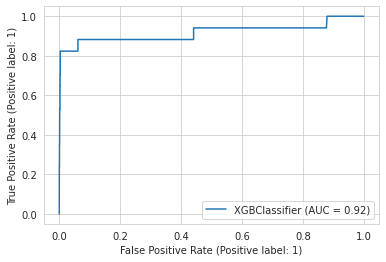

In [ ]:
metrics.plot_roc_curve(XGBC_model,x_val,y_val)
plt.show()

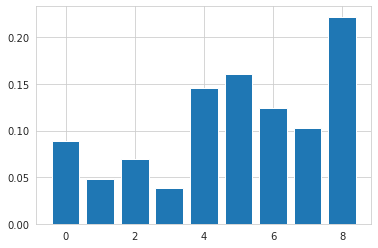

In [ ]:
plt.bar(range(len(XGBC_model.feature_importances_)), XGBC_model.feature_importances_)
plt.show()

In [ ]:
# feature importance
importance = dict(zip(x_train.columns, XGBC_model.feature_importances_))
importance

{'app_labels': 0.16044758,
 'channel_labels': 0.2220233,
 'day': 0.088595085,
 'device_labels': 0.123786494,
 'hour': 0.048538636,
 'ip_labels': 0.1457562,
 'min': 0.069628604,
 'os_labels': 0.10311112,
 'sec': 0.03811297}